<a href="https://colab.research.google.com/github/nicsim22/DS110-Content/blob/main/Lecture31AdvancedPandas_nosol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Pandas

*The database proved to be woefully incomplete, and Cynthia had to pull data from a variety of sources to make up for it.  Her earlier experience with DataFrames really didn't prepare her for the confusion that followed.*

*She had one file for contact info pulled from the web, another file for data from Instagram, and yet another for Facebook, and another for Amazon transactions - and then there was the census data file.  She'd have to merge all of these, then collapse individuals into rows representing cities or countries, all while handling individuals that were missing from one file and not another ... and Aubin asked for a pivot table showing how country and credit card possession interacted to influence infection rates, and she wasn't even quite sure what a pivot table was ... help!*

# Pivot tables

Pivot tables are a way of organizing data so that the **values of particular combinations of features are highlighted**.  For example, if you're looking at resale value of used cars, and have a long list of used cars before you, a pivot table could help you see the average resale value of a red 2013 Honda Fit.



Here's an example.

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"Model": ["Fit", "Corolla", "Civic", "Fit", "Civic",
                             "Corolla","Civic", "Fit", "Corolla",
                             "Fit", "Civic"],
                   "Color": ["red", "blue", "red", "silver", "red",
                             "blue", "silver", "red", "blue",
                             "silver", "silver"],
                   "Year": [2009, 2010, 2009, 2011, 2012,
                          2012, 2009, 2010, 2011, 2010, 2012],
                   "Price": [3300, 3600, 3000, 4000, 4200,
                             4300, 2000, 3000, 3600, 3200,4500]})
df

,Model,Color,Year,Price
0,Fit,red,2009,3300
1,Corolla,blue,2010,3600
2,Civic,red,2009,3000
3,Fit,silver,2011,4000
4,Civic,red,2012,4200
5,Corolla,blue,2012,4300
6,Civic,silver,2009,2000
7,Fit,red,2010,3000
8,Corolla,blue,2011,3600
9,Fit,silver,2010,3200


In [ ]:
table = pd.pivot_table(df, values='Price', #values --> main data used
                       index=['Model', 'Color'],
                       columns=['Year'], #look at all possible combinations of model, colour and year. where each is doenst matter, just affects presentation
                       aggfunc='mean') #what function we want to apply if all 3 agree --> mean
table
#with pivot table, can find avg stats without iterating through entire table
#NaN --> not a number

Year              2009    2010    2011    2012
Model   Color                                 
Civic   red     3000.0     NaN     NaN  4200.0
        silver  2000.0     NaN     NaN  4500.0
Corolla blue       NaN  3600.0  3600.0  4300.0
Fit     red     3300.0  3000.0     NaN     NaN
        silver     NaN  3200.0  4000.0     NaN

We've here chosen to analyze what happens when three car features "intersect" - an average price is listed for each combination.  (Or "NaN" if no such combination exists in the data.)  We chose in the pivot_table call what features would be on the left (index=...), what features would be on the top (columns=...), the name of the column containing values we're interested in (values), and how to combine multiple values for the same combination (aggfunc=np.mean).



We created a "MultiIndex" above by having two features to index on, but we could do the same stacking for columns instead.  Each entry still represents the intersection of 3 attributes.

In [ ]:
table = pd.pivot_table(df, values='Price',
                       index=['Color'],
                       columns=['Model','Year'],#just changing the presentation
                       aggfunc='mean')
table

Model    Civic         Corolla                     Fit                
Year      2009    2012    2010    2011    2012    2009    2010    2011
Color                                                                 
blue       NaN     NaN  3600.0  3600.0  4300.0     NaN     NaN     NaN
red     3000.0  4200.0     NaN     NaN     NaN  3300.0  3000.0     NaN
silver  2000.0  4500.0     NaN     NaN     NaN     NaN  3200.0  4000.0

With so many missing values, we could decide to not care about the year.  This will group entries with different years together, as long as they agree on Model and Color.

In [ ]:
table = pd.pivot_table(df, values='Price',
                       index=['Model'], columns=['Color'],
                       aggfunc='mean')
table

Color,blue,red,silver
Model,,,
Civic,NaN,3600.0,3250.0
Corolla,3833.333333,NaN,NaN
Fit,NaN,3150.0,3600.0


Now all the different years are being averaged together for the same color and model of car.


The fill_value parameter replaces the NaN's with some other value.

In [ ]:
table = pd.pivot_table(df, values='Price', index=['Model'],
                       columns=['Color'], aggfunc='mean',
                       fill_value=0) #fill NaN with values of 0
table

Color,blue,red,silver
Model,,,
Civic,0.000000,3600.0,3250.0
Corolla,3833.333333,0.0,0.0
Fit,0.000000,3150.0,3600.0


It's also possible to include multiple values and multiple statistics  in the same table, using different columns.  aggfunc can take a dictionary from value name to function instead of a single function as its argument.  The dictionary values can even be lists of functions instead of single functions. See the example below.

In [ ]:
table = pd.pivot_table(df, values=['Year','Price'],
                       index=['Model', 'Color'],
                       aggfunc={'Year': ['min','max'], 'Price': 'mean'}) #two kinds of stats that we are int in
# Default is to give columns alphabetically - we'll leave this alone
# since it's a little complicated to fix
table

Price  Year      
                       mean   max   min
Model   Color                          
Civic   red     3600.000000  2012  2009
        silver  3250.000000  2012  2009
Corolla blue    3833.333333  2012  2010
Fit     red     3150.000000  2010  2009
        silver  3600.000000  2011  2010

The pivot table is **for seeing patterns in data**, so you should **use whatever layout best illustrates answers your questions**.  For example, we could ask, does color change how a car's value changes over time?  As we're watching price change with the year over time, it makes sense to make the color a row, and the year a column.

In [ ]:
table = pd.pivot_table(df, values='Price', index=['Color'],
                       columns=['Year'], aggfunc='mean')
table

Year,2009,2010,2011,2012
Color,,,,
blue,NaN,3600.0,3600.0,4300.0
red,3150.0,3000.0,NaN,4200.0
silver,2000.0,3200.0,4000.0,4500.0


If the table itself isn't easy to read, it's straightforward to pass the pivot table to one of several kinds of plot with the plot() method of the dataframe.  See the pandas.DataFrame.plot() documentation for more types.

<Axes: xlabel='Color'>

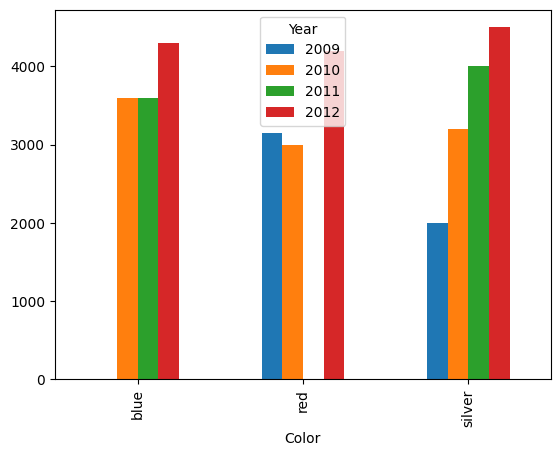

In [ ]:
table.plot(kind='bar')

# Exercise

Try predicting what the table will look like when the following pivot_table methods are called.

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"Student": ["Alice", "Bob", "Chu", "Dedue", "Egla", "Fatima","Grund"],
                   "GPA": [4.0, 3.5, 3.8, 2.8, 3.9, 3.7, 4.0],
                   "GradYear": [2022, 2023, 2022, 2024, 2022, 2024, 2023],
                   "Major": ["EE","CS","EE","CS","EE","CS","EE"],
                   "Took110": [False, True, False, True, False, False, False]})
df

,Student,GPA,GradYear,Major,Took110
0,Alice,4.0,2022,EE,False
1,Bob,3.5,2023,CS,True
2,Chu,3.8,2022,EE,False
3,Dedue,2.8,2024,CS,True
4,Egla,3.9,2022,EE,False
5,Fatima,3.7,2024,CS,False
6,Grund,4.0,2023,EE,False


In [ ]:
table = pd.pivot_table(df, values='GPA', index=['Major'], columns=['GradYear'], aggfunc='mean')
table

GradYear,2022,2023,2024
Major,,,
CS,NaN,3.5,3.25
EE,3.9,4.0,NaN


In [ ]:
table = pd.pivot_table(df, values='GPA', index=['Major','GradYear'], aggfunc={'GPA': ['mean', 'max']})
table

max  mean
Major GradYear           
CS    2023      3.5  3.50
      2024      3.7  3.25
EE    2022      4.0  3.90
      2023      4.0  4.00

In [ ]:
table = pd.pivot_table(df, values='GPA', index=['Major'], columns=['GradYear','Took110'], aggfunc='mean') #two features that are passed into column --> so tiered structure
table

GradYear  2022  2023        2024      
Took110  False False True  False True 
Major                                 
CS         NaN   NaN   3.5   3.7   2.8
EE         3.9   4.0   NaN   NaN   NaN

# Groupby

A related method is **groupby()**, which **groups the entries by a particular value they have in common** (such as same model of car).  This allows for a **quick mean()** of the other features of those individuals.  It's like a pivot table, but it perhaps more convenient as it requires **fewer parameters** (in exchange for being a little less flexible).

In [ ]:
# numeric_only added for pandas 2, avoid mean being confused by strings --> exclude name column
df.groupby(["Major"]).mean(numeric_only=True)

,GPA,GradYear,Took110
Major,,,
CS,3.333333,2023.666667,0.666667
EE,3.925000,2022.250000,0.000000


It may make sense to run the groupby only on particular columns, which should include the one you want to run groupby on.

In [ ]:
df[["GPA", "Major"]].groupby(["Major"]).mean() #index into it only the columns that we want GPA and major
#group by--> main thing we want to look at at left-most column

,GPA
Major,
CS,3.333333
EE,3.925000


You can also groupby multiple criteria, so it finds the average (or other statistic) for each combination.  Groupby's result then starts to look like a pivot table (it's actually a MultiIndex).

In [ ]:
df.groupby(["Major","GradYear"]).mean(numeric_only=True) #want to look at both major and gradyear, so groupby those

GPA  Took110
Major GradYear               
CS    2023      3.50      1.0
      2024      3.25      0.5
EE    2022      3.90      0.0
      2023      4.00      0.0

# Exercise

Use groupby on the cars dataframe to find the average price for each model.  Try to only include the price information, and not the year.

In [ ]:
cars = pd.DataFrame({"Model": ["Fit", "Corolla", "Civic", "Fit", "Civic",
                             "Corolla","Civic", "Fit", "Corolla"],
                   "Color": ["red", "blue", "red", "silver", "red",
                             "blue", "silver", "red", "blue"],
                   "Year": [2009, 2010, 2009, 2011, 2013,
                          2013, 2009, 2010, 2011],
                   "Price": [3300, 3600, 3000, 4000, 4000,
                             4000, 2000, 3000, 3000]})

In [ ]:
# TODO

df[["Model", "Color", "Price"]].groupby["Model", "Color"].mean(numeric_only=True)

KeyError: "None of [Index(['Model', 'Color', 'Price'], dtype='object')] are in the [columns]"

# Merging tables

You can *join* tables on the basis of shared key values.  You need to pass the name of each table's column to join on, as left_on and right_on.  The join will create a table with rows that combine rows from each table, using the column to join on as the identity that links both tables.

In [ ]:
grade_df = pd.DataFrame({'Name': ['Alice', 'Bob', 'Chu', 'Daisy'],
                    'GPA': [4.0, 3.5, 3.9, 3.1]})

major_df = pd.DataFrame({'Name': ['Alice', 'Bob', 'Chu', 'Daisy'],
                        'Major': ['EE', 'CS', 'EE', 'CS']})

merged_df = grade_df.merge(major_df, left_on = 'Name',
                           right_on = 'Name') #dont need left_on and right_on, system will just try to match on its own if not
merged_df

,Name,GPA,Major
0,Alice,4.0,EE
1,Bob,3.5,CS
2,Chu,3.9,EE
3,Daisy,3.1,CS


Now, it's possible that either one of the tables is missing some keys that the other has.  The default behavior is to **ignore any rows that are missing from the other table, in both tables**.  This is called an **'inner join**.'  But, if you want some other kind of join, you can specify this in the "how" parameter.  An **"outer" join creates rows for records that have either key**, and a "left" or "right" join creates rows according to just the left table's or right table's keys. Outer merge shows NaN for missing data on one of the sides.

Thus, inner merge is more useful --> drops people who are not found in either of the two.

In [ ]:
# These two lists now differ in their D person

#inner merge --> eg. if name column is missing from one df, will drop that column

grade_df = pd.DataFrame({'Name': ['Alice', 'Bob', 'Chu', 'Dominique'],
                    'GPA': [4.0, 3.5, 3.9,3.1]})

major_df = pd.DataFrame({'Name': ['Alice', 'Bob', 'Chu', 'Daisy'],
                        'Major': ['EE', 'CS', 'EE', 'CS']})

outer_merge = grade_df.merge(major_df, how="outer",
                             left_on='Name', right_on='Name')
outer_merge

,Name,GPA,Major
0,Alice,4.0,EE
1,Bob,3.5,CS
2,Chu,3.9,EE
3,Daisy,NaN,CS
4,Dominique,3.1,NaN


In [ ]:
inner_merge = grade_df.merge(major_df, how="inner",
                             left_on='Name',right_on='Name') # also the default
inner_merge

,Name,GPA,Major
0,Alice,4.0,EE
1,Bob,3.5,CS
2,Chu,3.9,EE


In [ ]:
left_merge = grade_df.merge(major_df, how="left", #everyone who is in the left df is kept, thus daisy dropped because not in left df
                            left_on='Name',right_on='Name')
left_merge

,Name,GPA,Major
0,Alice,4.0,EE
1,Bob,3.5,CS
2,Chu,3.9,EE
3,Dominique,3.1,NaN


# Exercise

If the two lists of keys to merge on are ['X', 'Y', 'Z'] and ['W', 'X', 'Y'], predict which keys are kept in an inner merge, outer merge, and right merge.

//Inner merge: 'X', 'Y'//
Outer merge: all //
Right merge: 'W', 'X', 'Y'

# Missing values

The values NaN (not a number), None, and pd.NA are all used for missing values in Pandas.  As a first pass to dealing with missing values, isna() returns True in exactly those places in the data where values are missing.

In [ ]:
outer_merge.isna() #to check if it is null, NaN or None, etc

#shows that daisy GPA is null, Dominique major is null

,Name,GPA,Major
0,False,False,False
1,False,False,False
2,False,False,False
3,False,True,False
4,False,False,True


One reasonable response is to drop the missing value rows altogether.  The dropna() method does this.

In [ ]:
inner_merge = outer_merge.dropna() #drop rows in outer merge with NA values
inner_merge

,Name,GPA,Major
0,Alice,4.0,EE
1,Bob,3.5,CS
2,Chu,3.9,EE


Another reasonable response would be to fill the missing data with default values.  The fillna() method does this.  For individual entries, you could set them by hand, but fillna() will work across the DataFrame or Series.  (Recall that columns are Series, and you can access them with dot operators.)

In [ ]:
outer_merge.GPA = outer_merge.GPA.fillna(0) #if na value in gpa column, fill with 0 instead
outer_merge.Major = outer_merge.Major.fillna("Undeclared")
outer_merge

,Name,GPA,Major
0,Alice,4.0,EE
1,Bob,3.5,CS
2,Chu,3.9,EE
3,Daisy,0.0,CS
4,Dominique,3.1,Undeclared


There are further ways to interpolate the data for missing values(such as passing a mean() to fillna), but dropping the values or
inserting default values will be what you want in most cases.  See the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) for more on how to interpolate values.

# Datetime

A special kind of data that can come up as you're processing data files is dates and times.  The Python datetime type is useful for processing time, which has all kinds of special cases you'd rather not worry about yourself:  leap years, specifying a time zone, handling the different numbers of days in a month, and so on.

Datetime objects store the year, month, day, hour, minute, second, and microseconds of a time.  They can also store timezone information.

In [ ]:
import datetime

now = datetime.datetime.today()
print(now)

2024-11-18 19:03:05.873996


Datetime objects have addition and subtraction operations overridden, as well as comparison operations overridden.  This let you **work with times and dates easily.**

In [ ]:
a_little_later = datetime.datetime.today() #new generated datetime
print(a_little_later - now)  # produces timedelta object, prints as hours : minutes : seconds.microseconds
print(a_little_later < now)

#produces difference between time found in this codebox vs previous when prog was ran

0:00:51.023363
False


You can call datetime.datetime.strptime(*string*, *format-string*) on a string that contains date information to convert it to a datetime object.  *Format-string* is a string that shows the datetime module where to find the hours, years, and so forth - see below.

In [ ]:
my_datetime_string = "10/31/24 12:00am"
# m = month, d = day, y = year, I = 12-hour hour, M = minutes, p = am/pm
# See https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
my_datetime = datetime.datetime.strptime(my_datetime_string, "%m/%d/%y %I:%M%p")
print(my_datetime)

2024-10-31 00:00:00


Though pandas tries to determine the formats of columns automatically, it doesn't necessarily do a great job with dates.  Call pd.to_datetime() to turn a column of strings into a column of datetimes.  The first argument is the Series to convert, and you also need to pass a format string similar to the ones datetime.datetime.strptime() uses.

In [ ]:
# Skip this cell if not working in Google Colab
from google.colab import files

uploaded = files.upload() # sample_dates.csv

Saving sample_dates.csv to sample_dates.csv


In [ ]:
!cat sample_dates.csv

Date, Sales
10/24/24, 100
10/25/24, 120
10/26/24, 122


In [ ]:
import pandas as pd

df = pd.read_csv('sample_dates.csv')

df['Date'] = pd.to_datetime(df['Date'], format = "%m/%d/%y") #transform the date format above into datetime format

df.dtypes #to double check type, if date has been changed to datetype format

,0
Date,datetime64[ns]
Sales,int64


In [ ]:
# Demonstrating date math with the result
print(df['Date'][2] - df['Date'][0])

2 days 00:00:00
